In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.functional as F

from options import Options
from models import *
from dataset import *
from utils import *

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

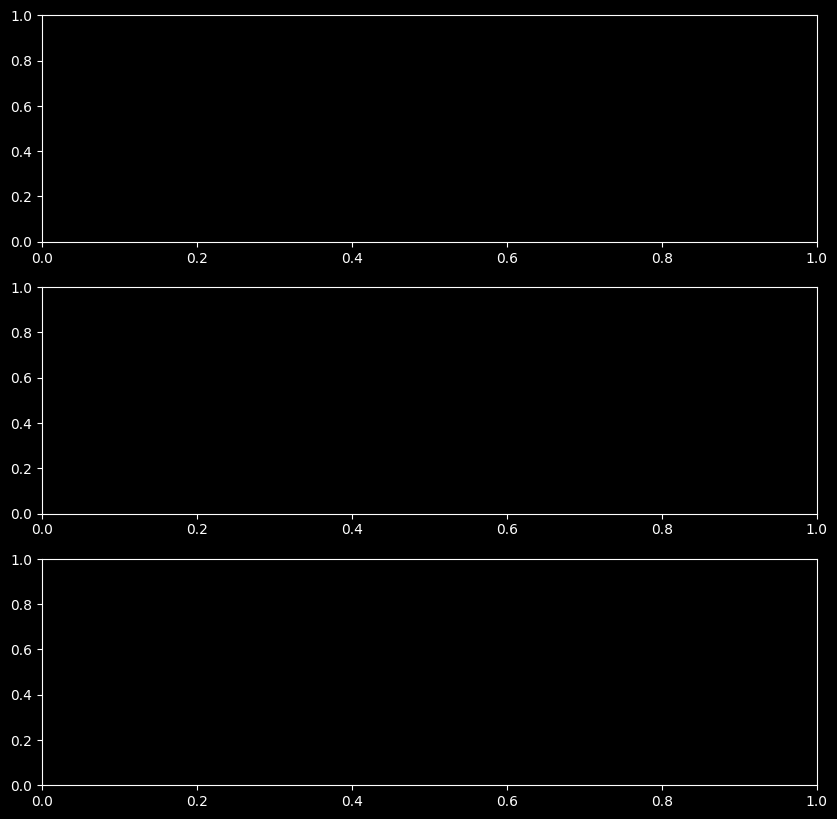

In [56]:
fig, axs = plt.subplots(len(history),1,figsize=(10,10))
for model_folder in os.listdir('models'):
    try:
        opt = Options()
        opt.load_options(model_folder)

        state = torch.load(f"{model_folder}/best.pth")
        history = torch.load(f"{model_folder}/history.pth")

        Dataset = Datasets[opt.dataset]
        model = Models[opt.model](opt).to(device)

        test_df = pd.read_csv(f"{opt.data_folder}/test.csv")
        test_set = Dataset(test_df, opt)
        test_loader = DataLoader(test_set, batch_size=30, shuffle=False)

        model.load_state_dict(state['state_dict'])
        # model = model.to(device)
        test_best = state['epoch']

        for i, key in enumerate(history.keys()):
            ax = axs[i]
            ax.set_title(key)

            ax.plot(history[key])
            ax.axvline(test_best, color='red')
    except:
        pass

In [50]:
# Confusion matrix and accuracies
y_pred, y_test, test_accuracy = predict(model, test_loader)
print(test_accuracy)

0.3413


In [51]:
y_pred, y_test = torch.tensor(y_pred).detach().numpy(), torch.tensor(y_test).detach().numpy()

In [52]:
# Succ
test_df['y_pred'] = y_pred
test_df['y_test'] = y_test
test_df.loc[y_pred==y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
1,A brown dog and black and white dog run along ...,Two squirrels run after acorns in the grass.,contradiction,0,0
3,An old Indian man dressed in rags sleeps on th...,An old Indian man is dressed up,contradiction,0,0
11,"A woman in a blue uniform, with long curly red...",The horse is dead.,contradiction,0,0
14,Man with black shirt and sunglasses makes some...,A woman cuts celery.,contradiction,0,0
18,A lady in a dark coat is sitting with many peo...,A woman is standing with her back to a dog.,contradiction,0,0
...,...,...,...,...,...
9983,Two men heavily immersed in a conversation wor...,The men are at work.,-,0,0
9984,"A man, boy and a white dog are looking at a di...",A man is all alone looking at postcards.,contradiction,0,0
9986,A crowd of people is looking at something outs...,People are looking inside,contradiction,0,0
9992,An older man is speaking to a boy while both a...,Older man is sleeping,contradiction,0,0


In [53]:
# Fails
test_df.loc[y_pred!=y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
0,A kid bored in a train with brown hair and his...,A child is riding the train from New York to B...,neutral,1,0
2,A person in full astronaut suit and gear train...,A female astronaut adjusting to the feeling of...,neutral,1,0
4,A bunch of people are standing all together in...,A group of people are planning something.,neutral,1,0
5,"Two girls (one dressed in blue, and one dresse...",The winner gets a free soda.,neutral,1,0
6,Many people gathered in a room with several pe...,Parents gathers for a local high school concert,neutral,1,0
...,...,...,...,...,...
9995,Man sitting playing guitar.,A man is sitting and strumming a guitar.,entailment,2,0
9996,Two women stand in the street both wearing mat...,Two women are dancing in the street wearing dr...,neutral,1,0
9997,This person looks to be snowboarding on a very...,Young snowboarder sizing up their next jump,entailment,2,0
9998,A group of cleaners are sweeping up animal fec...,A group of cleaners after a parade.,entailment,2,0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.34      1.00      0.51      3413
           1       0.00      0.00      0.00      3219
           2       0.00      0.00      0.00      3368

    accuracy                           0.34     10000
   macro avg       0.11      0.33      0.17     10000
weighted avg       0.12      0.34      0.17     10000



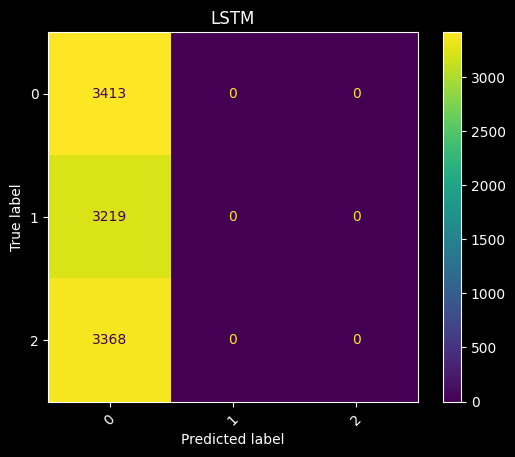

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation = 45)
plt.title(f"{model_folder.split('/')[1]}")
print(classification_report(y_test, y_pred))